Coupling map:


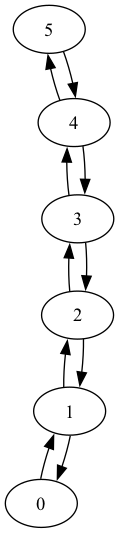

In [7]:
from gate_level.spillover_noise_use_case.generic_spillover.spillover_effect_on_subsystem import circuit_context

from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter, Gate, Qubit
from typing import List, Optional
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt
from rl_qoc.helpers.transpiler_passes import CausalConePass
# Define the environment
from gymnasium.spaces import Box
from gymnasium.wrappers import RescaleObservation, FlattenObservation
from rl_qoc import ContextAwareQuantumEnvironment, QEnvConfig, ContextSamplingWrapper, GateTarget, QiskitConfig
from qiskit_aer import AerSimulator, noise

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

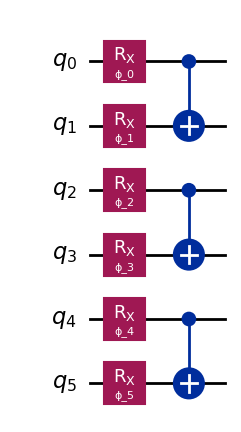

In [8]:
circuit = circuit_context(num_qubits, rotation_axes, rotation_parameters, cm)
circuit.draw('mpl')


## Classical Crosstalk

Text(0.5, 1.0, 'Spillover rate matrix')

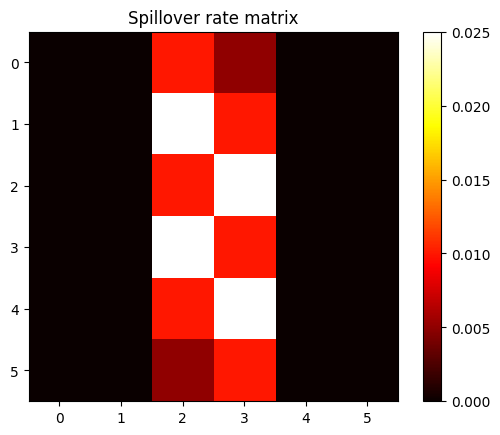

In [9]:
from microwave_crosstalk_pass import MicrowaveCrosstalkPass
from static_zz_crosstalk_pass import StaticZZCrosstalkPass

# Define noise-coupling matrix with gamma values (example values)
# gamma_matrix = np.zeros((num_qubits, num_qubits))
# gamma_matrix[0, 1] = 0.0  # γ_0->1
# gamma_matrix[0, 3] = 0.0  # γ_0->3
# gamma_matrix[1, 2] = 0.0  # γ_1->2
# gamma_matrix[2, 2] = 0.0  # γ_2->2
# gamma_matrix[2, 3] = 0.05  # γ_2->3
# gamma_matrix[3, 2] = 0.05  # γ_3->2
# gamma_matrix[4, 3] = 0.0  # γ_4->3
# gamma_matrix[5, 4] = 0.0  # γ_5->4
# # gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)
#
# # Generate another gamma matrix based on coupling map defined above
# gamma_matrix = 0.01 * np.eye(num_qubits)
# for edge in cm.get_edges():
#     gamma_matrix[edge[0], edge[1]] = 0.05
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 3] = 0.005  # γ_0->3
gamma_matrix[1, 3] = 0.01  # γ_1->3
gamma_matrix[2, 3] = 0.025  # γ_2->3
gamma_matrix[3, 3] = 0.01  # γ_2->3
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 3] = 0.01  # γ_5->3
gamma_matrix[0, 2] = 0.01  # γ_0->2
gamma_matrix[1, 2] = 0.025  # γ_1->2
gamma_matrix[2, 2] = 0.01  # γ_1->2
gamma_matrix[3, 2] = 0.025  # γ_3->2
gamma_matrix[4, 2] = 0.01  # γ_4->2
gamma_matrix[5, 2] = 0.005  # γ_5->2
# gamma_matrix = np.random.rand(num_qubits, num_qubits, 3)
# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [10]:
def angle_dependence(op: Gate, qargs: Optional[List[Qubit]] = None):
    if op.name in ["rx", "ry", "rz"]:
        angle = op.params[0]
        return [angle, angle, angle**2]
    else: 
        raise ValueError(f"Gate {op.name} not supported")
mw_pass = MicrowaveCrosstalkPass(gamma_matrix.tolist(), angle_dependence)


Crosstalk rate matrix is 2D, adding a new dimension
(6, 6, 3)


## Readout Error

In [11]:


# For each qubit, generate a realistic readout error matrix (2x2), where each row sums to 1 and diagonal dominates.
readout_error_matrices = np.zeros((num_qubits, 2, 2))
for i in range(num_qubits):
    # Generate a higher probability for correct readout, and lower for error
    p0 = np.random.uniform(0.9, 0.99)  # prob correctly reading |0>
    p1 = np.random.uniform(0.9, 0.99)  # prob correctly reading |1>
    readout_error_matrices[i] = np.array([
        [p0, 1 - p0],  # row for prep |0>
        [1 - p1, p1]   # row for prep |1>
    ])

readout_error_matrix = np.array([[0.95, 0.05], [0.05, 0.95]])
noise_model = noise.NoiseModel(["x", "rx", "ry", "rz", "cx", "h", "sdg", "t", "tdg"])
for i in range(num_qubits):
    noise_model.add_readout_error(readout_error_matrices[i], [i])

## Define Backend

In [12]:
from qiskit.transpiler import Target, InstructionProperties
from qiskit.circuit.library import get_standard_gate_name_mapping as gate_map
from qiskit_aer.library import *
save_instructions = {"save_amplitudes": SaveAmplitudes,
"save_probabilities": SaveProbabilities,
"save_statevector": SaveStatevector,
"save_unitary": SaveUnitary,
"save_density_matrix": SaveDensityMatrix,
"save_superop": SaveSuperOp,
"save_expectation_value": SaveExpectationValue,
}
gate_map = gate_map()
target = Target("crosstalk_target", num_qubits=num_qubits, dt=1e-9, granularity=4, min_length=16)
sq_gate_duration = 20e-9
tq_gate_duration = 150e-9
sq_gate_property_dict = {(i,): InstructionProperties(duration=sq_gate_duration) for i in range(num_qubits)}
phase_gate_property_dict = {(i,): InstructionProperties(duration=0) for i in range(num_qubits)}
tq_gate_property_dict = {(i, j): InstructionProperties(duration=tq_gate_duration) for i, j in cm.get_edges()}      
target.add_instruction(gate_map["rx"], sq_gate_property_dict)
target.add_instruction(gate_map["ry"], sq_gate_property_dict)
target.add_instruction(gate_map["rz"], phase_gate_property_dict)
target.add_instruction(gate_map["cx"], tq_gate_property_dict)
target.add_instruction(gate_map["rzx"], tq_gate_property_dict)
target.add_instruction(gate_map["h"], sq_gate_property_dict)
target.add_instruction(gate_map["sdg"], phase_gate_property_dict)
target.add_instruction(gate_map["t"], phase_gate_property_dict)
target.add_instruction(gate_map["tdg"], phase_gate_property_dict)
for instruction_name, instruction_class in save_instructions.items():
    target.add_instruction(instruction_class, name= instruction_name)

backend = AerSimulator(target=target, noise_model=noise_model)

## Static ZZ crosstalk

In [13]:
zz_couplings = {(0, 1): 0.05, (1, 2): 0.05, (2, 3): 0.05, (3, 4): 0.05, (4, 5): 0.05}
zz_pass = StaticZZCrosstalkPass(zz_couplings, target.durations())


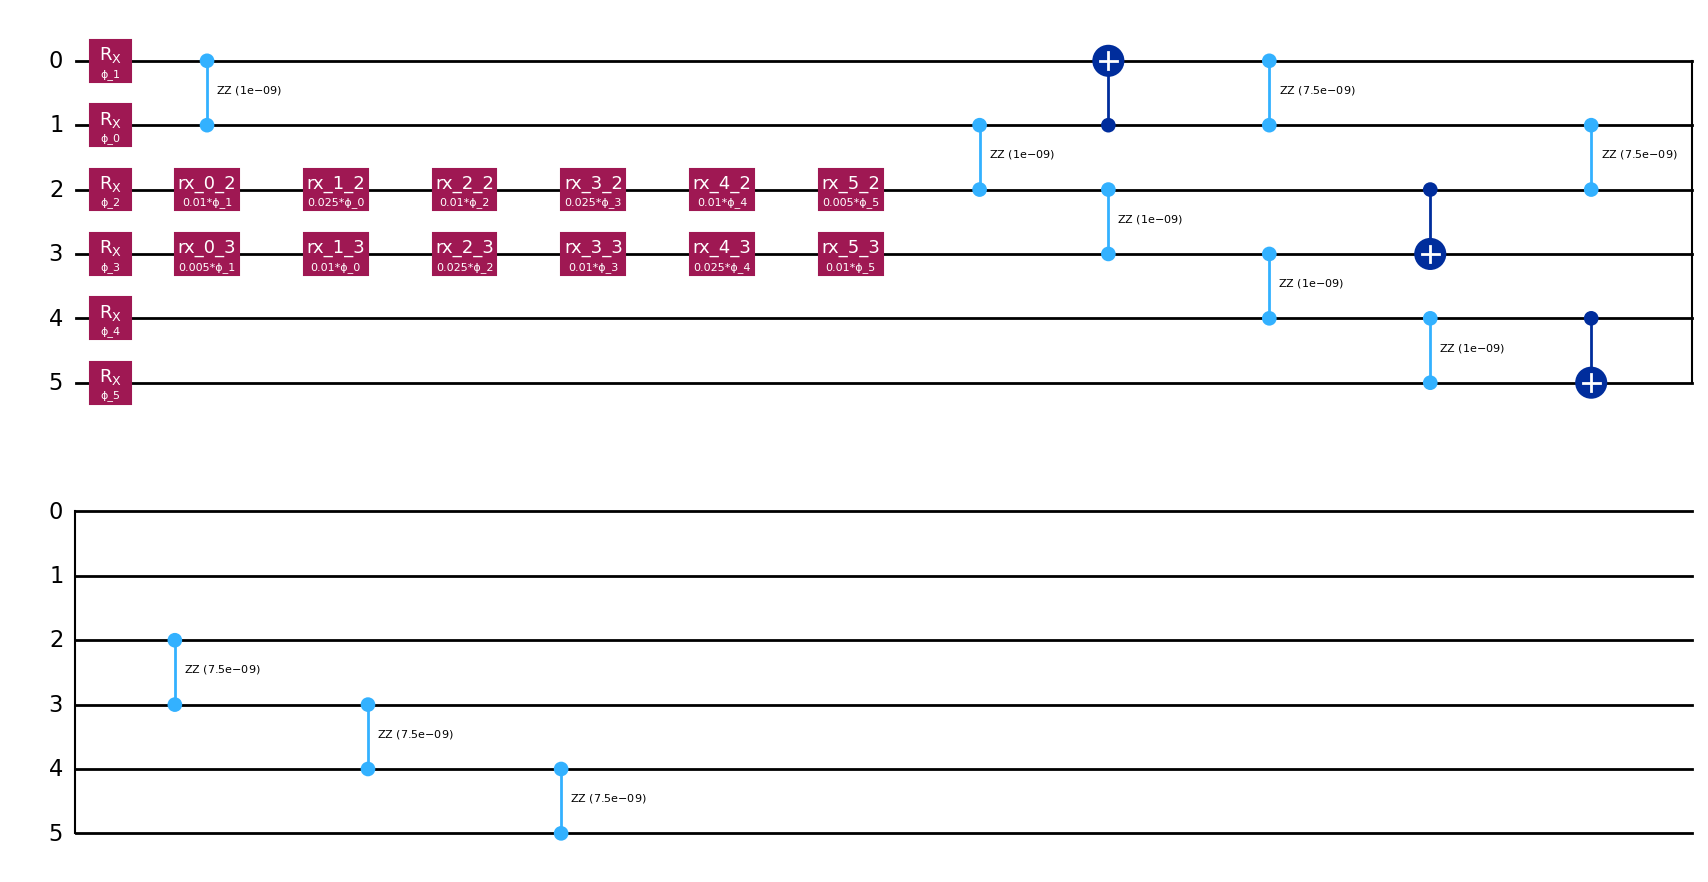

In [24]:
from qiskit.transpiler import generate_preset_pass_manager
pm = PassManager([zz_pass, mw_pass])
full_pm = generate_preset_pass_manager(backend=backend, scheduling_method="asap")
new_circuit = full_pm.run(circuit)
new_circuit2 = pm.run(new_circuit)
new_circuit2.draw('mpl')

In [42]:
from qiskit.circuit import QuantumRegister
# Add here custom ansatz CX gate

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{target.gate.name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        new_params[0],
        -0.5 * np.pi,
        0.5 * np.pi,
        q_reg[0],
    )
    my_qc.u(
        0,
        new_params[1],
        new_params[2],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])


    qc.append(my_qc.to_gate(label=my_qc.name), q_reg)

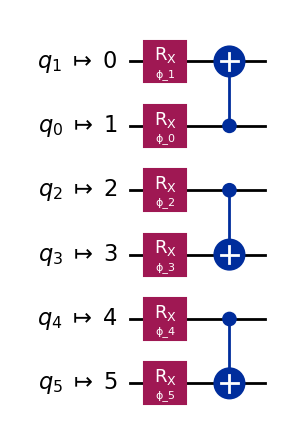

In [14]:
from qiskit.transpiler import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, scheduling_method="asap")
pm.post_scheduling
new_circuit:QuantumCircuit = pm.run(circuit)
new_circuit.draw('mpl')




In [56]:
new_circuit.op_start_times

[0, 0, 20, 0, 0, 20, 0, 0, 20]

In [65]:
target.durations().dt

1e-09